<a href="https://colab.research.google.com/github/Raunak22-Dev/Digit_Recognition_CNN/blob/main/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import matplotlib.pyplot as plt

In [2]:
#Device Agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#Transfroming the image

transfrom=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])


In [4]:
#Setup training data and Testing Data
train_data=torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transfrom,
    target_transform=None
)

test_data=torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transfrom,
    target_transform=None
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.84MB/s]


In [5]:
len(train_data),len(test_data)

(60000, 10000)

In [6]:
class_names=train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape:torch.Size([1, 28, 28])
Image shape:torch.Size([28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

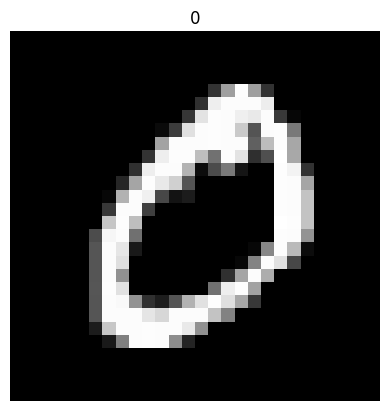

In [7]:
#Visualizing our data

image,label=train_data[1]
print(f"Image shape:{image.shape}")
print(f"Image shape:{image.squeeze().shape}")
plt.imshow(image.squeeze(),cmap="gray")
plt.title(label)
plt.axis("off")

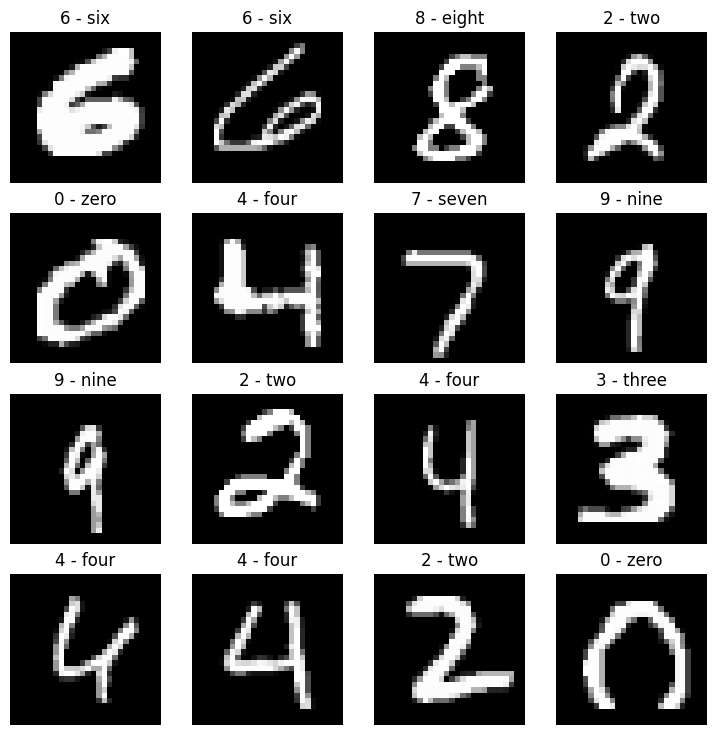

In [8]:
#Plot more images
torch.manual_seed(42)
torch.cuda.manual_seed(42)

fig=plt.figure(figsize=(9,9))
rows,cols=4,4

for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  img,label=train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis("off")

In [9]:
# Prepare DataLoader

train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

test_dataloader=DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=False
)

In [10]:
len(train_dataloader),len(test_dataloader)

(938, 157)

In [11]:
#Check out what's inside the traning dataloader

train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

###Make the CNN Model


In [12]:
#Making the Convolutional Neural Network(CNN) model

class MNIST(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [13]:
model=MNIST(input_shape=1, #bcoz it has only one color (i.e gray)
            hidden_units=32,
            output_shape=len(class_names))

In [14]:
#Creating loss_fn and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.01)

In [15]:
from tqdm.auto import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training settings
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch+1}\n" + "-"*30)

    # Training
    train_loss = 0
    train_correct = 0
    model.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Calculate correct predictions
        train_correct += (y_pred.argmax(dim=1) == y).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_accuracy = train_correct / len(train_dataloader.dataset)

    # Testing
    test_loss = 0
    test_correct = 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss += loss.item()

            test_correct += (test_pred.argmax(dim=1) == y_test).sum().item()

    test_loss /= len(test_dataloader)
    test_accuracy = test_correct / len(test_dataloader.dataset)

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_accuracy*100:.2f}%")


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 1
------------------------------
Train Loss: 0.1773 | Train Acc: 94.49%
Test  Loss: 0.0903 | Test  Acc: 97.34%

Epoch: 2
------------------------------
Train Loss: 0.0721 | Train Acc: 97.88%
Test  Loss: 0.0532 | Test  Acc: 98.25%

Epoch: 3
------------------------------
Train Loss: 0.0652 | Train Acc: 98.04%
Test  Loss: 0.0607 | Test  Acc: 98.36%

Epoch: 4
------------------------------
Train Loss: 0.0598 | Train Acc: 98.20%
Test  Loss: 0.0436 | Test  Acc: 98.54%

Epoch: 5
------------------------------
Train Loss: 0.0578 | Train Acc: 98.33%
Test  Loss: 0.0633 | Test  Acc: 98.10%


In [16]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, n=6):
    model.eval()
    images_shown = 0

    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            preds_classes = preds.argmax(dim=1)

            # Create a horizontal row of subplots
            fig, axes = plt.subplots(1, n, figsize=(15, 3))

            for i in range(n):
                img = images[i].cpu().squeeze()
                axes[i].imshow(img, cmap="gray")
                axes[i].set_title(f"P: {preds_classes[i].item()}\nA: {labels[i].item()}")
                axes[i].axis("off")

            plt.tight_layout()
            plt.show()
            return


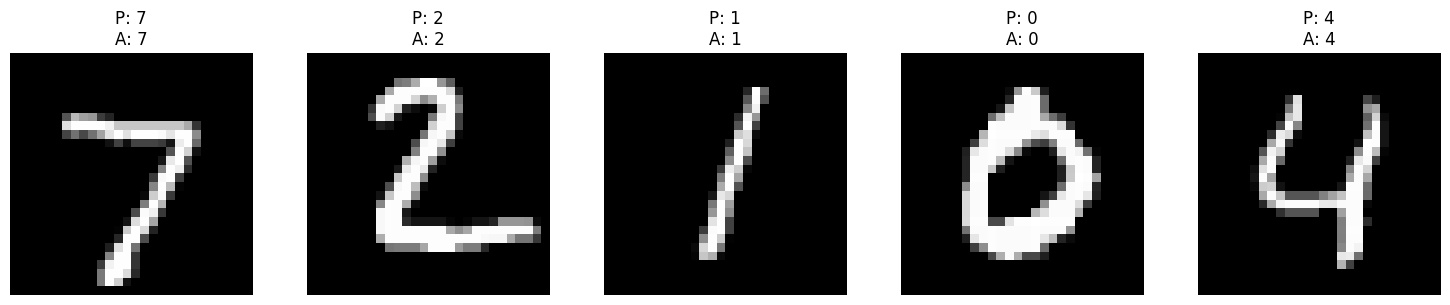

In [17]:
plot_predictions(model, test_dataloader, n=5)


###Use your custom Data to Predict the hand written digit

In [19]:
from google.colab import files
from pathlib import Path
from PIL import Image, ImageOps
import shutil

# 1. Upload image
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]

# 2. Move to target path
target_dir = Path("data")
target_dir.mkdir(parents=True, exist_ok=True)
custom_image_path = target_dir / uploaded_filename  # Keep original filename
shutil.move(uploaded_filename, custom_image_path)
print(f"✅ Image moved to: {custom_image_path}")

# 3. Define transformation (with optional inversion)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # invert (black digit on white -> white digit on black)
    transforms.Normalize((0.5,), (0.5,))
])

# 4. Load and preprocess image
image = Image.open(custom_image_path).convert("L")  # Ensure grayscale
image = ImageOps.invert(image)  # invert black and white manually if needed
input_tensor = transform(image).unsqueeze(0).to(device)  # shape [1, 1, 28, 28]

# 5. Predict
model.eval()
with torch.inference_mode():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

# 6. Show result
print(f"✅ Predicted Digit: {pred_class}")
plt.imshow(image, cmap="gray")
plt.title(f"Predicted: {pred_class}")
plt.axis("off")
plt.show()


###Save the model

In [20]:
torch.save(model.state_dict(), "MNIST_CNN.pth")


### Reuse the model  

In [21]:
# Step 1: Define the model class again (same architecture)
class MNIST(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [25]:
# Step 2: Create a model instance
model = MNIST(input_shape=1, hidden_units=32, output_shape=10)

# Step 3: Load the saved state dict
model.load_state_dict(torch.load("MNIST_CNN.pth"))

# Step 4: Move model to the appropriate device
model.to(device)
model.eval()  # Important: set to evaluation mode


MNIST(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [26]:
# Example inference
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        preds = model(X)
        pred_labels = preds.argmax(dim=1)
        print(pred_labels[:5])
        break


tensor([7, 2, 1, 0, 4], device='cuda:0')


In [35]:
pip install --upgrade nbformat nbconvert


### Note:-The below code is only For upload purpose for github it is not a part of the code so avoid it  

In [34]:
# import nbformat
# from google.colab import _message

# # Get the current notebook as a raw dict
# notebook_raw = _message.blocking_request('get_ipynb')['ipynb']

# # Remove broken metadata if it exists
# notebook_raw['metadata'].pop('widgets', None)

# # Convert to proper NotebookNode format
# notebook_clean = nbformat.from_dict(notebook_raw)

# # Save cleaned notebook
# with open("Digit_Recognition_CNN.ipynb", "w") as f:
#     nbformat.write(notebook_clean, f)

# print("✅ Cleaned notebook saved as Clean_Digit_Recognition.ipynb")


✅ Cleaned notebook saved as Clean_Digit_Recognition.ipynb
